# Rotating Optical Constants

Using the optical tensor derived from the linear dichrosim measured with experimental nexafs,
this notebook works though the process of converting from the molecular reference frame to the
material reference frame. The molecular reference frame is defined by the orientation of
the transition dipole moment associate with the primary $\pi^*$ resonant feature. This TDM orientation
defines the out of plane, extrodinary, or $zz$ optical axis. The ordinary, or in-plane optical axes
are defined to be perpandicular to this $zz$ axis.

The material optical model can be derived by the ensemble average of properly rotated molecules.
We approximate this process by rotating the optical model by the average molecular tilt angle,
i.e.,

$$
    \tilde{n}(\vec\theta) = R(\theta)\tilde{n}'R(\vec\theta)^T
$$

where $R(\theta)$ is the rotation matrix describing the proper molecular rotation. Most molecules
are approximated as uniaxial materials, azamuthal symmetry. In this case, the only angle that maters
is the polar angle $\theta$.


,μ₂₀,μ₄₀,μ₅₅,μ₇₀,μ₉₀,Energy [eV]
1,4793.8398,4787.5586,4773.2593,4766.6880,4761.0200,279.999586
2,4794.9214,4788.6357,4773.5957,4766.7251,4760.8813,280.100006
3,4796.2891,4789.6636,4774.0200,4766.9688,4760.8457,280.199906
4,4797.5137,4790.8784,4774.6538,4767.3296,4761.0391,280.299378
5,4799.3608,4792.2939,4775.4473,4767.8291,4761.2002,280.399842


[]

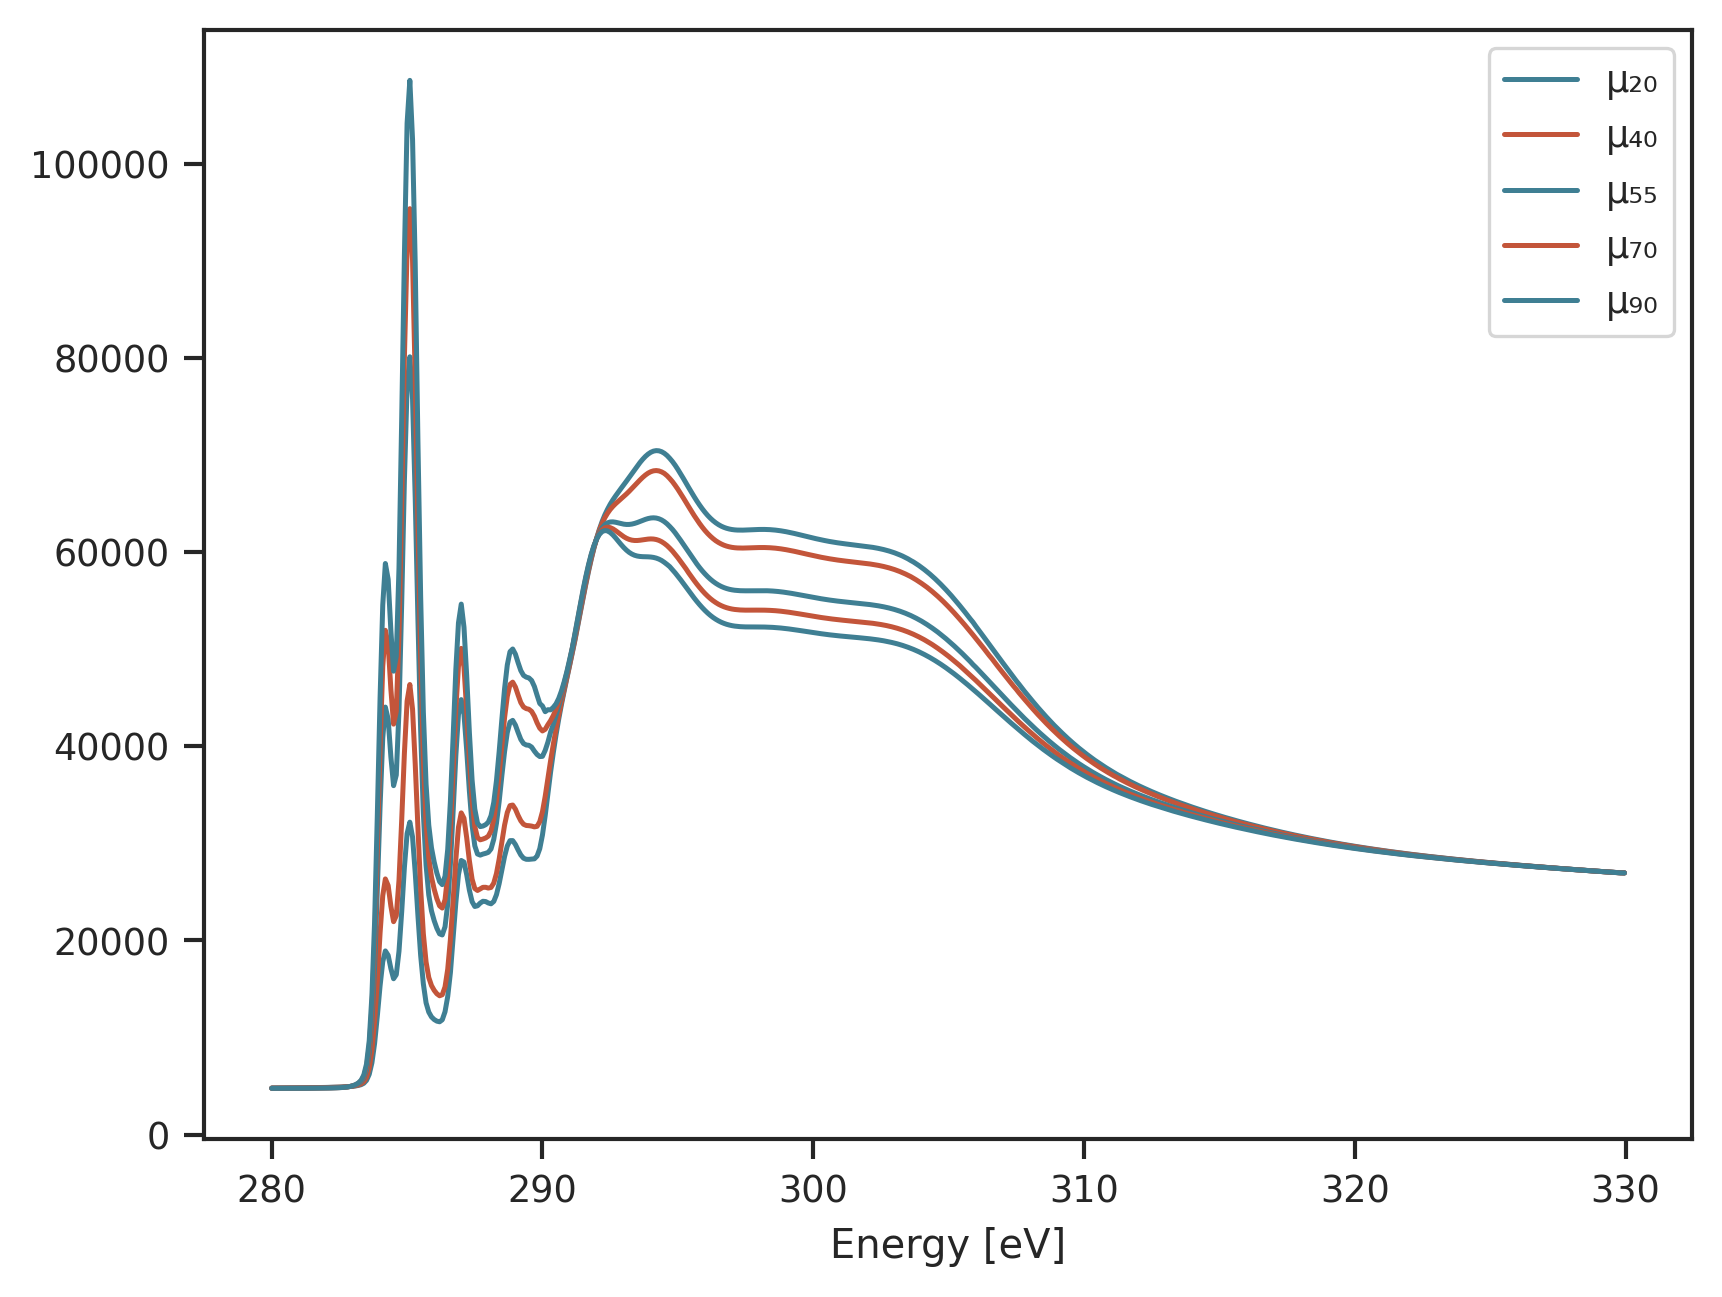

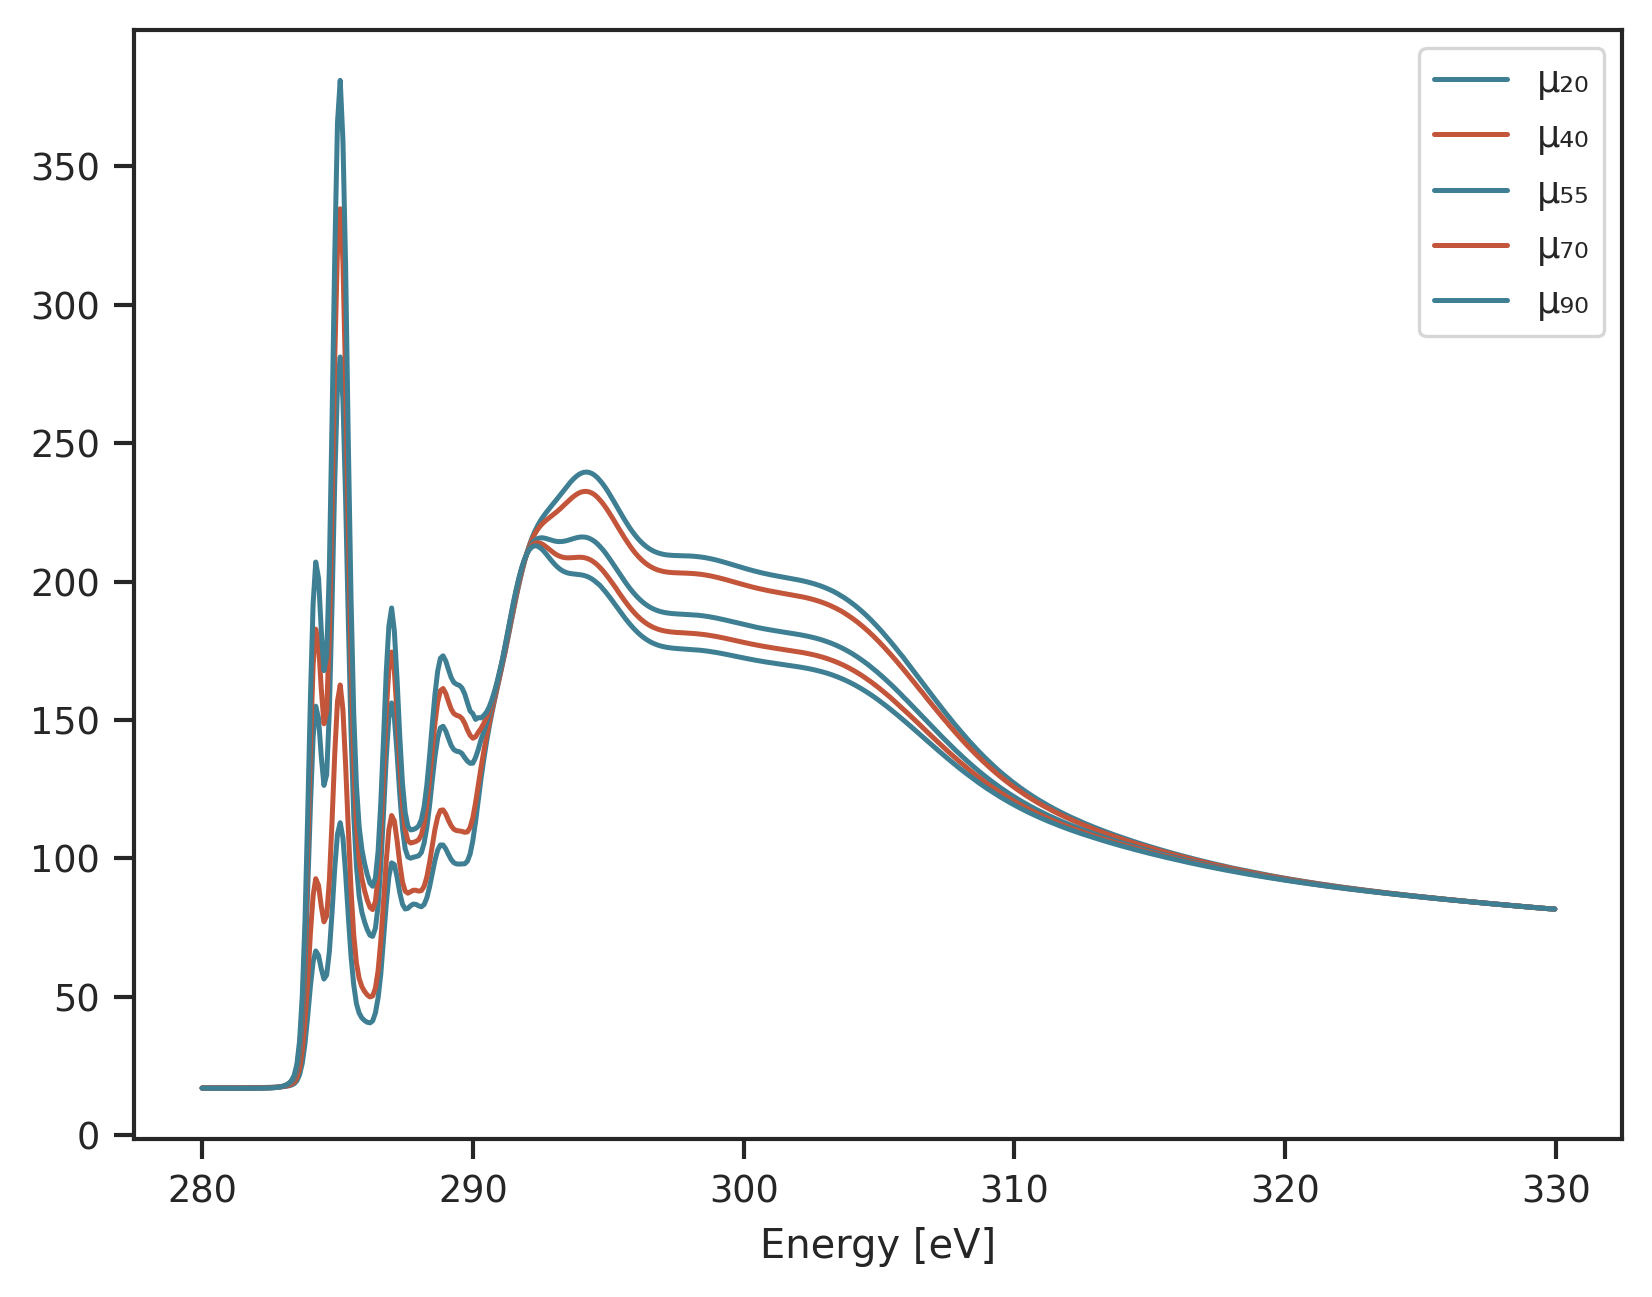

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

sns.set_palette(sns.diverging_palette(220, 20, n=2))
plt.rcParams.update({"figure.dpi": 300})
sns.set_context("paper")
sns.set_style("ticks")

from pathlib import Path

sns.set_style("ticks")

directory = Path().home() / "projects/xrr_notebooks"

raw = pd.read_csv("C32H16N8Zn.raw")
# drop the first row
raw = raw.drop(0)
energy_cols = [col for col in raw.columns if "Energy" in col]
# make a new column e [eV] that is the average of the energy columns
raw["Energy [eV]"] = raw[energy_cols].mean(axis=1)
raw = raw.drop(energy_cols, axis=1).sort_values("Energy [eV]")
# update column names to be more descriptive
raw.columns = ["μ₂₀", "μ₄₀", "μ₅₅", "μ₇₀", "μ₉₀", "Energy [eV]"]
# Divide the columns by the energy column
mu = raw.div(raw["Energy [eV]"], axis=0)
mu["Energy [eV]"] = raw["Energy [eV]"]

display(raw.head())
raw.plot(x="Energy [eV]")
mu.plot(x="Energy [eV]")
plt.plot()

<Axes: xlabel='Energy [eV]'>

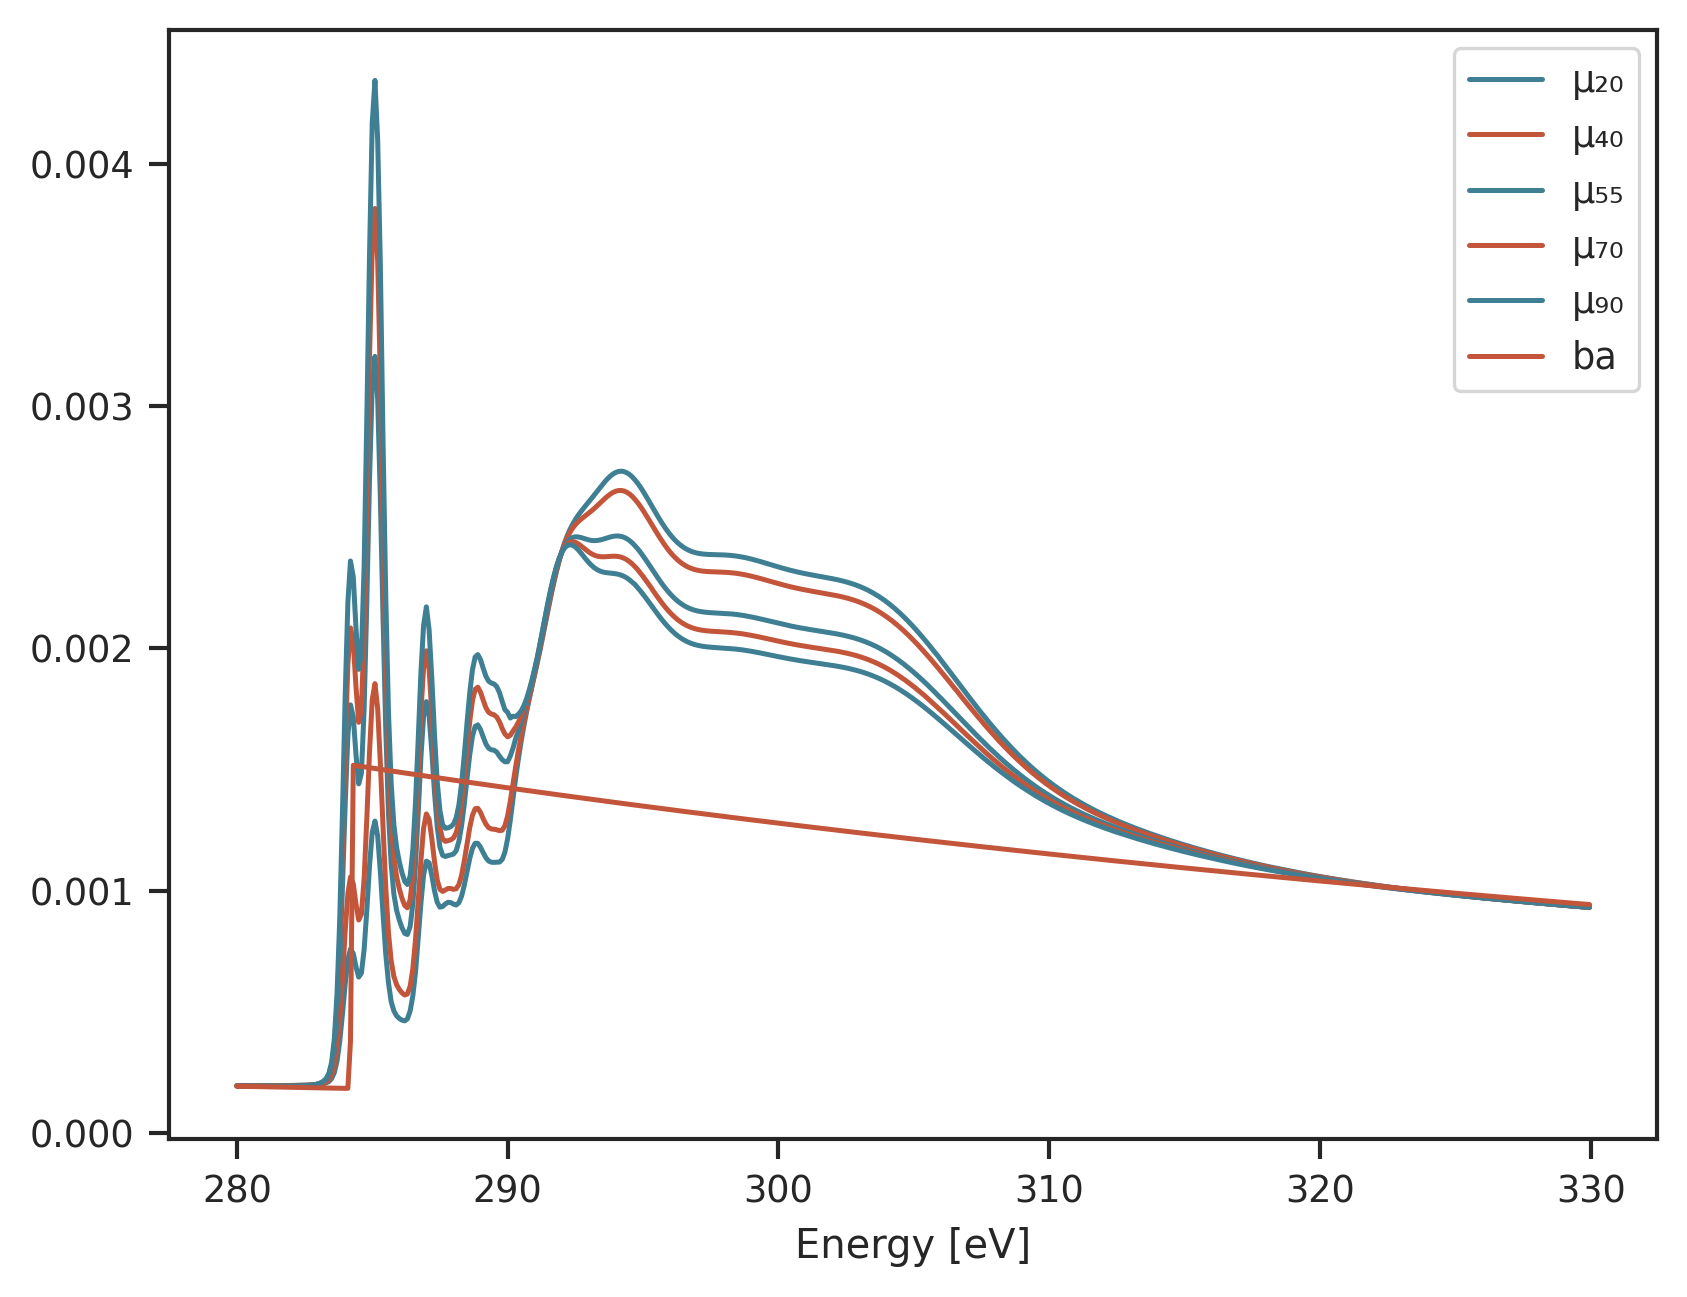

In [7]:
# Normalize the data to bare atom values
from periodictable import xsf
import matplotlib.pyplot as plt

ba = (
    -1
    * xsf.index_of_refraction(
        "C32H16N8Zn1", density=1.16, energy=raw["Energy [eV]"].values * 1e-3
    ).imag
)

# Using the first and last three points, dtermine the scale factor to normalize the data
scale_pre = np.mean(ba[:3] / mu["μ₂₀"].values[:3])
scale_pos = np.mean(ba[-3:] / mu["μ₂₀"].values[-3:])
scale = (scale_pre + scale_pos) / 2
mu_norm = mu.mul(scale)
mu_norm["ba"] = ba
mu_norm["Energy [eV]"] = mu["Energy [eV]"]
mu_norm.plot(x="Energy [eV]")

<Axes: xlabel='Energy [eV]'>

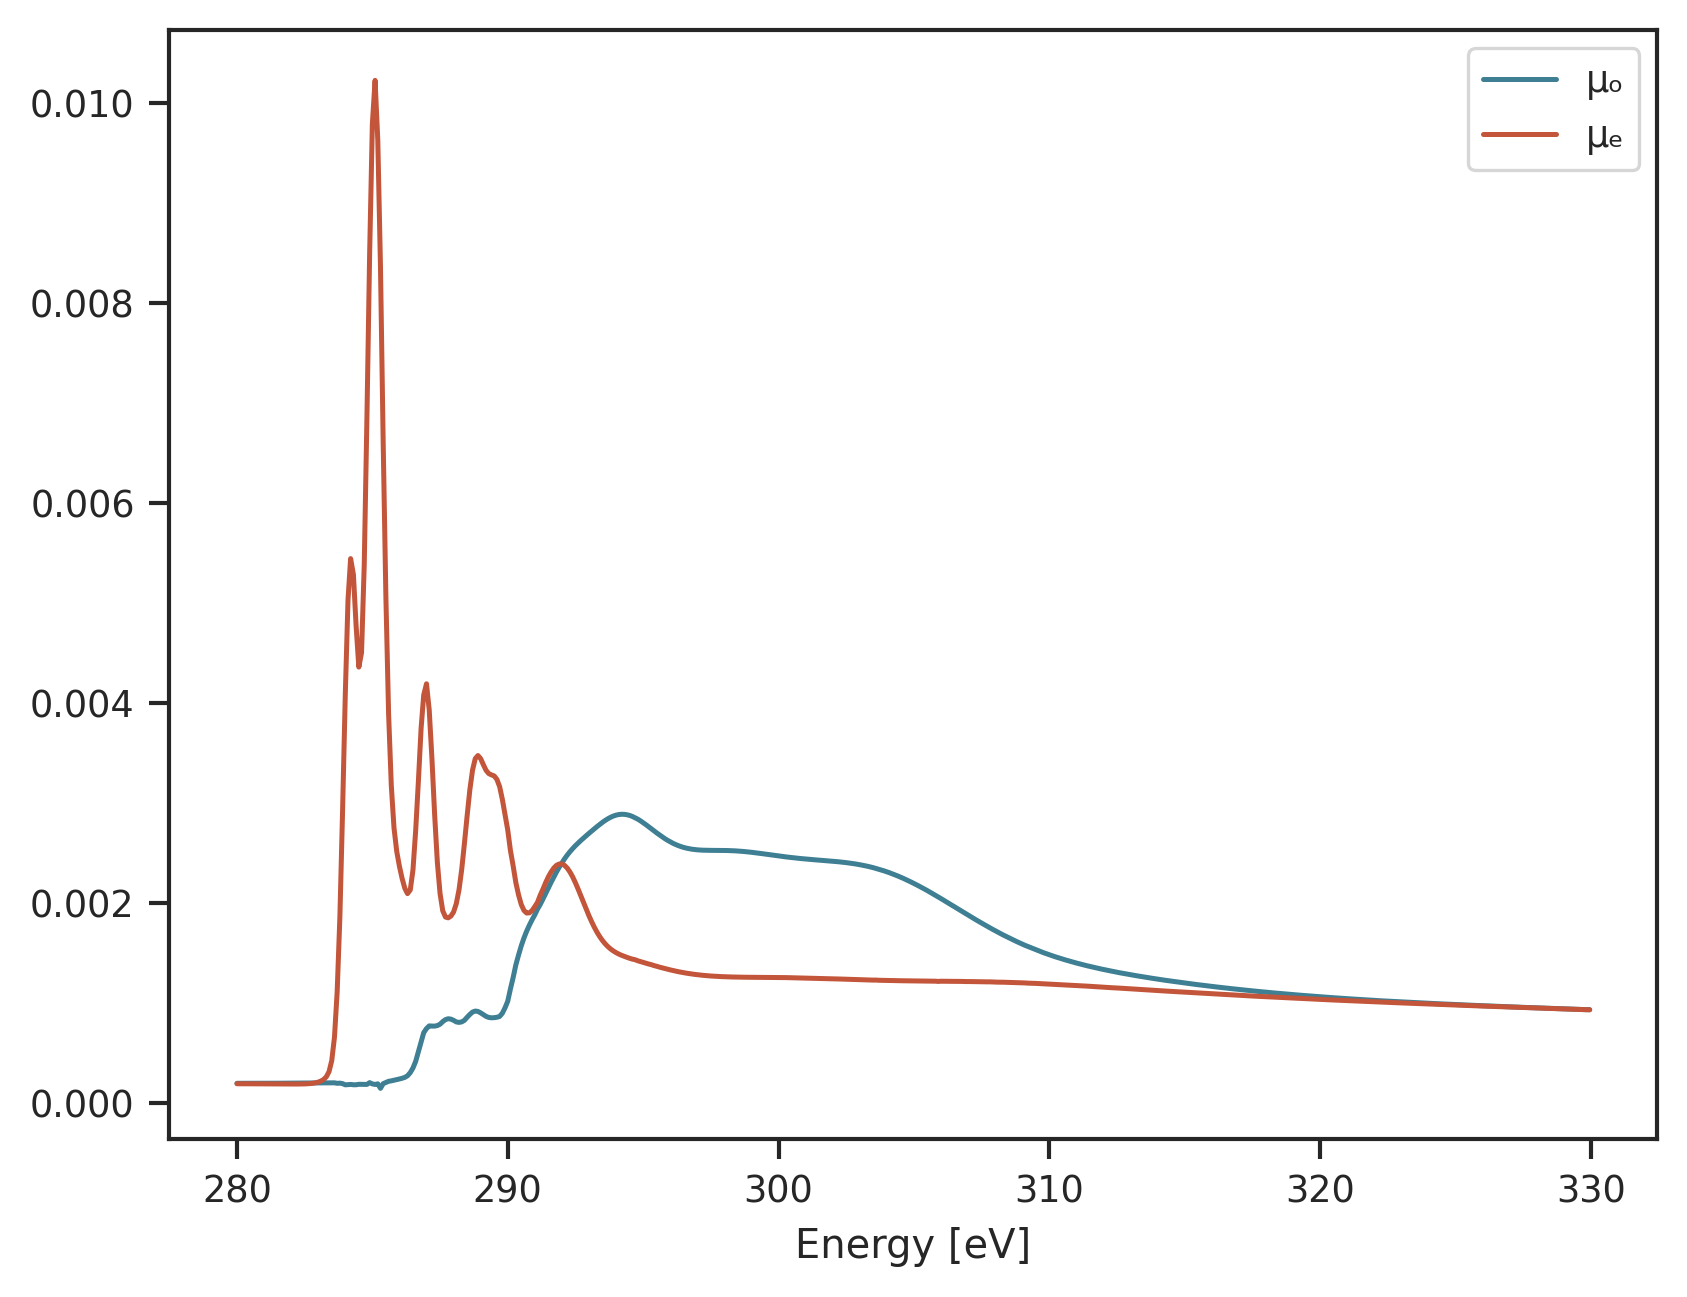

In [8]:
# Determine the difference spectrum for the dataset
input = pd.DataFrame()
input["Energy [eV]"] = mu_norm["Energy [eV]"]
input["diff_spec"] = mu_norm["μ₉₀"] - mu_norm["μ₂₀"]
# Max difference spectrum is the primary peak
primary_peak = input.loc[input["diff_spec"].idxmax()]
lower_bound = mu_norm.loc[mu_norm["ba"].idxmin()]

mu_av = mu_norm["μ₅₅"].loc[primary_peak.name]

ratio = mu_av / primary_peak["diff_spec"]
bound = lower_bound["ba"] / primary_peak["diff_spec"]

input["μₒ"] = mu_norm["μ₅₅"] - (ratio - bound) * input["diff_spec"]
input["μₑ"] = mu_norm["μ₇₀"] + 2 * ratio * input["diff_spec"]

input.plot(x="Energy [eV]", y=["μₒ", "μₑ"])

,Energy [eV],$\delta_\parallel$,$\delta_\perp$,$\beta_\parallel$,$\beta_\perp$
0,10.00000,-0.228939,-0.230440,0.278840,0.278840
1,10.16170,-0.243137,-0.244592,0.281537,0.281537
2,10.18225,-0.234211,-0.235659,0.281919,0.281919
3,10.20280,-0.226376,-0.227818,0.282295,0.282295
4,10.24390,-0.213223,-0.214654,0.283033,0.283033


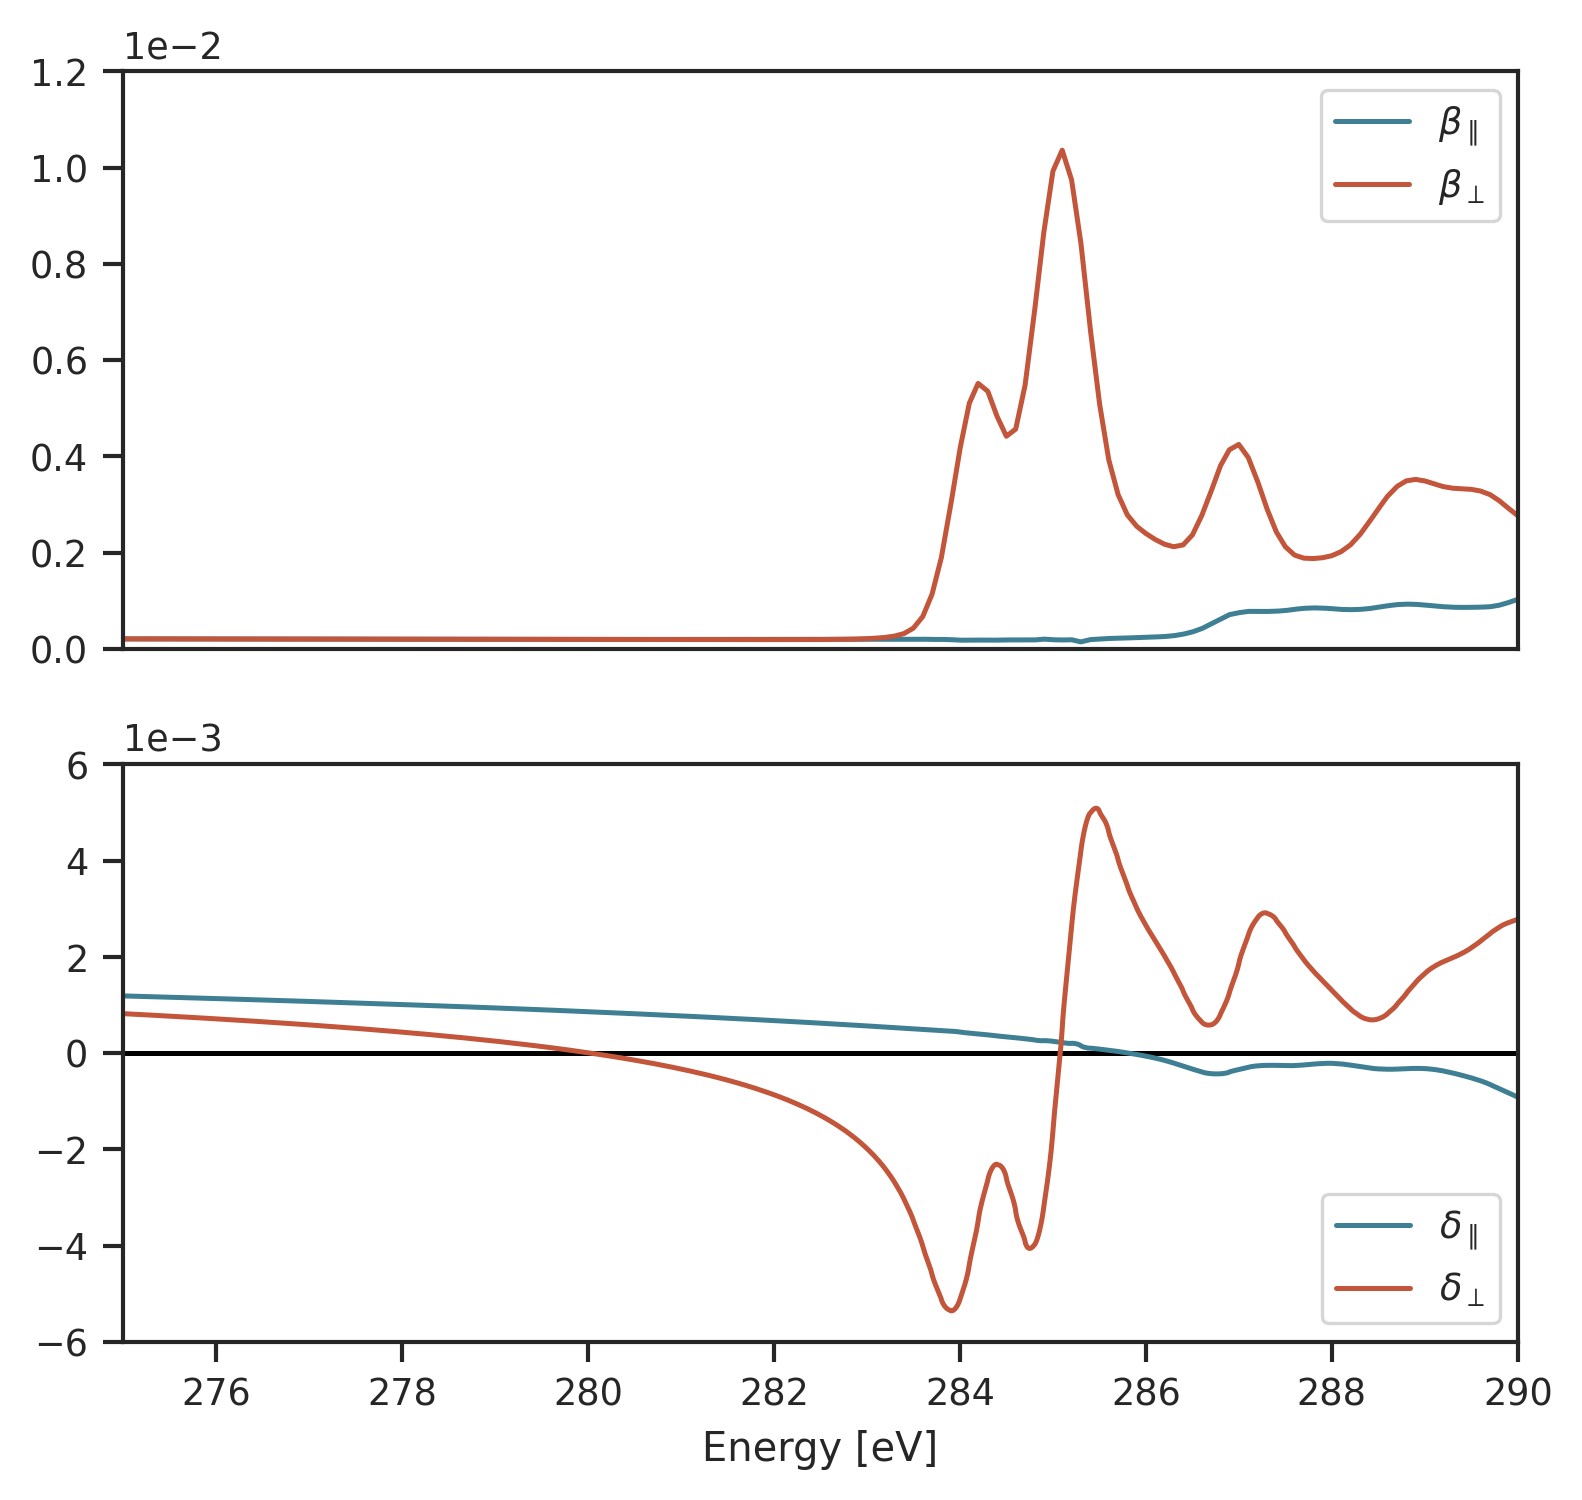

In [ ]:
# Kramers-Kronig transform
import kkcalc as kk
from numpy import interp

preped_data_set_e = input[["Energy [eV]", "μₑ"]].values
preped_data_set_o = input[["Energy [eV]", "μₒ"]].values


calc_e = kk.kk_calculate_real(
    preped_data_set_e,
    "C32H16N8Zn1",
    input_data_type="beta",
    load_options=None,
    merge_points=[input["Energy [eV]"].min(), input["Energy [eV]"].max()],
    add_background=False,
    fix_distortions=False,
    curve_tolerance=0.05,
    curve_recursion=100,
)

calc_o = kk.kk_calculate_real(
    preped_data_set_o,
    "C32H16N8Zn1",
    input_data_type="beta",
    load_options=None,
    merge_points=[input["Energy [eV]"].min(), input["Energy [eV]"].max()],
    add_background=False,
    fix_distortions=False,
    curve_tolerance=0.05,
    curve_recursion=100,
)

stoich = kk.data.ParseChemicalFormula("C32H16N8Zn1")
mass = kk.data.calculate_FormulaMass(stoich)

δ_ip = kk.data.convert_data(
    calc_o[:, [0, 1]], "ASF", "refractive_index", Density=1.16, Formula_Mass=mass
)

δ_op = kk.data.convert_data(
    calc_e[:, [0, 1]], "ASF", "refractive_index", Density=1.16, Formula_Mass=mass
)

β_ip = kk.data.convert_data(
    calc_o[:, [0, 2]], "ASF", "refractive_index", Density=1.16, Formula_Mass=mass
)

β_op = kk.data.convert_data(
    calc_e[:, [0, 2]], "ASF", "refractive_index", Density=1.16, Formula_Mass=mass
)

en = δ_ip[:, 0] if δ_ip[:, 0].size > δ_op[:, 0].size else δ_op[:, 0]

# interpolate the lower points to the higher points
δ_ip = interp(en, δ_ip[:, 0], δ_ip[:, 1])
δ_op = interp(en, δ_op[:, 0], δ_op[:, 1])
β_ip = interp(en, β_ip[:, 0], β_ip[:, 1])
β_op = interp(en, β_op[:, 0], β_op[:, 1])

ooc = pd.DataFrame(
    {
        "Energy [eV]": en,
        r"$\delta_\parallel$": δ_ip,
        r"$\delta_\perp$": δ_op,
        r"$\beta_\parallel$": β_ip,
        r"$\beta_\perp$": β_op,
    }
)
fig, ax = plt.subplots(
    nrows=2, sharex=True, gridspec_kw={"hspace": 0.2}, figsize=(6, 5.5)
)

ooc.plot(x="Energy [eV]", y=[r"$\beta_\parallel$", r"$\beta_\perp$"], ax=ax[0])
ooc.plot(x="Energy [eV]", y=[r"$\delta_\parallel$", r"$\delta_\perp$"], ax=ax[1])

display(ooc.head())

ax[0].set_xlim(275, 290)
ax[0].set_ylim(0, 0.012)
ax[0].tick_params(axis="x", which="both", bottom=False, top=False, labelbottom=False)
ax[0].ticklabel_format(style="sci", axis="y", scilimits=(0, 0))
ax[1].set_xlim(275, 290)
ax[1].ticklabel_format(style="sci", axis="y", scilimits=(0, 0))
ax[1].axhline(0, color="k", zorder=-1)
ax[1].set_ylim(-0.006, 0.006)
ax[1].legend(loc="lower right")

In [10]:
def R(theta: float) -> np.ndarray:
    return np.array([[np.cos(theta), -np.sin(theta)], [np.sin(theta), np.cos(theta)]])


n = np.zeros((len(en), 2, 2), dtype=complex)
n[:, 0, 0] = δ_ip + 1j * β_ip
n[:, 1, 1] = δ_op + 1j * β_op

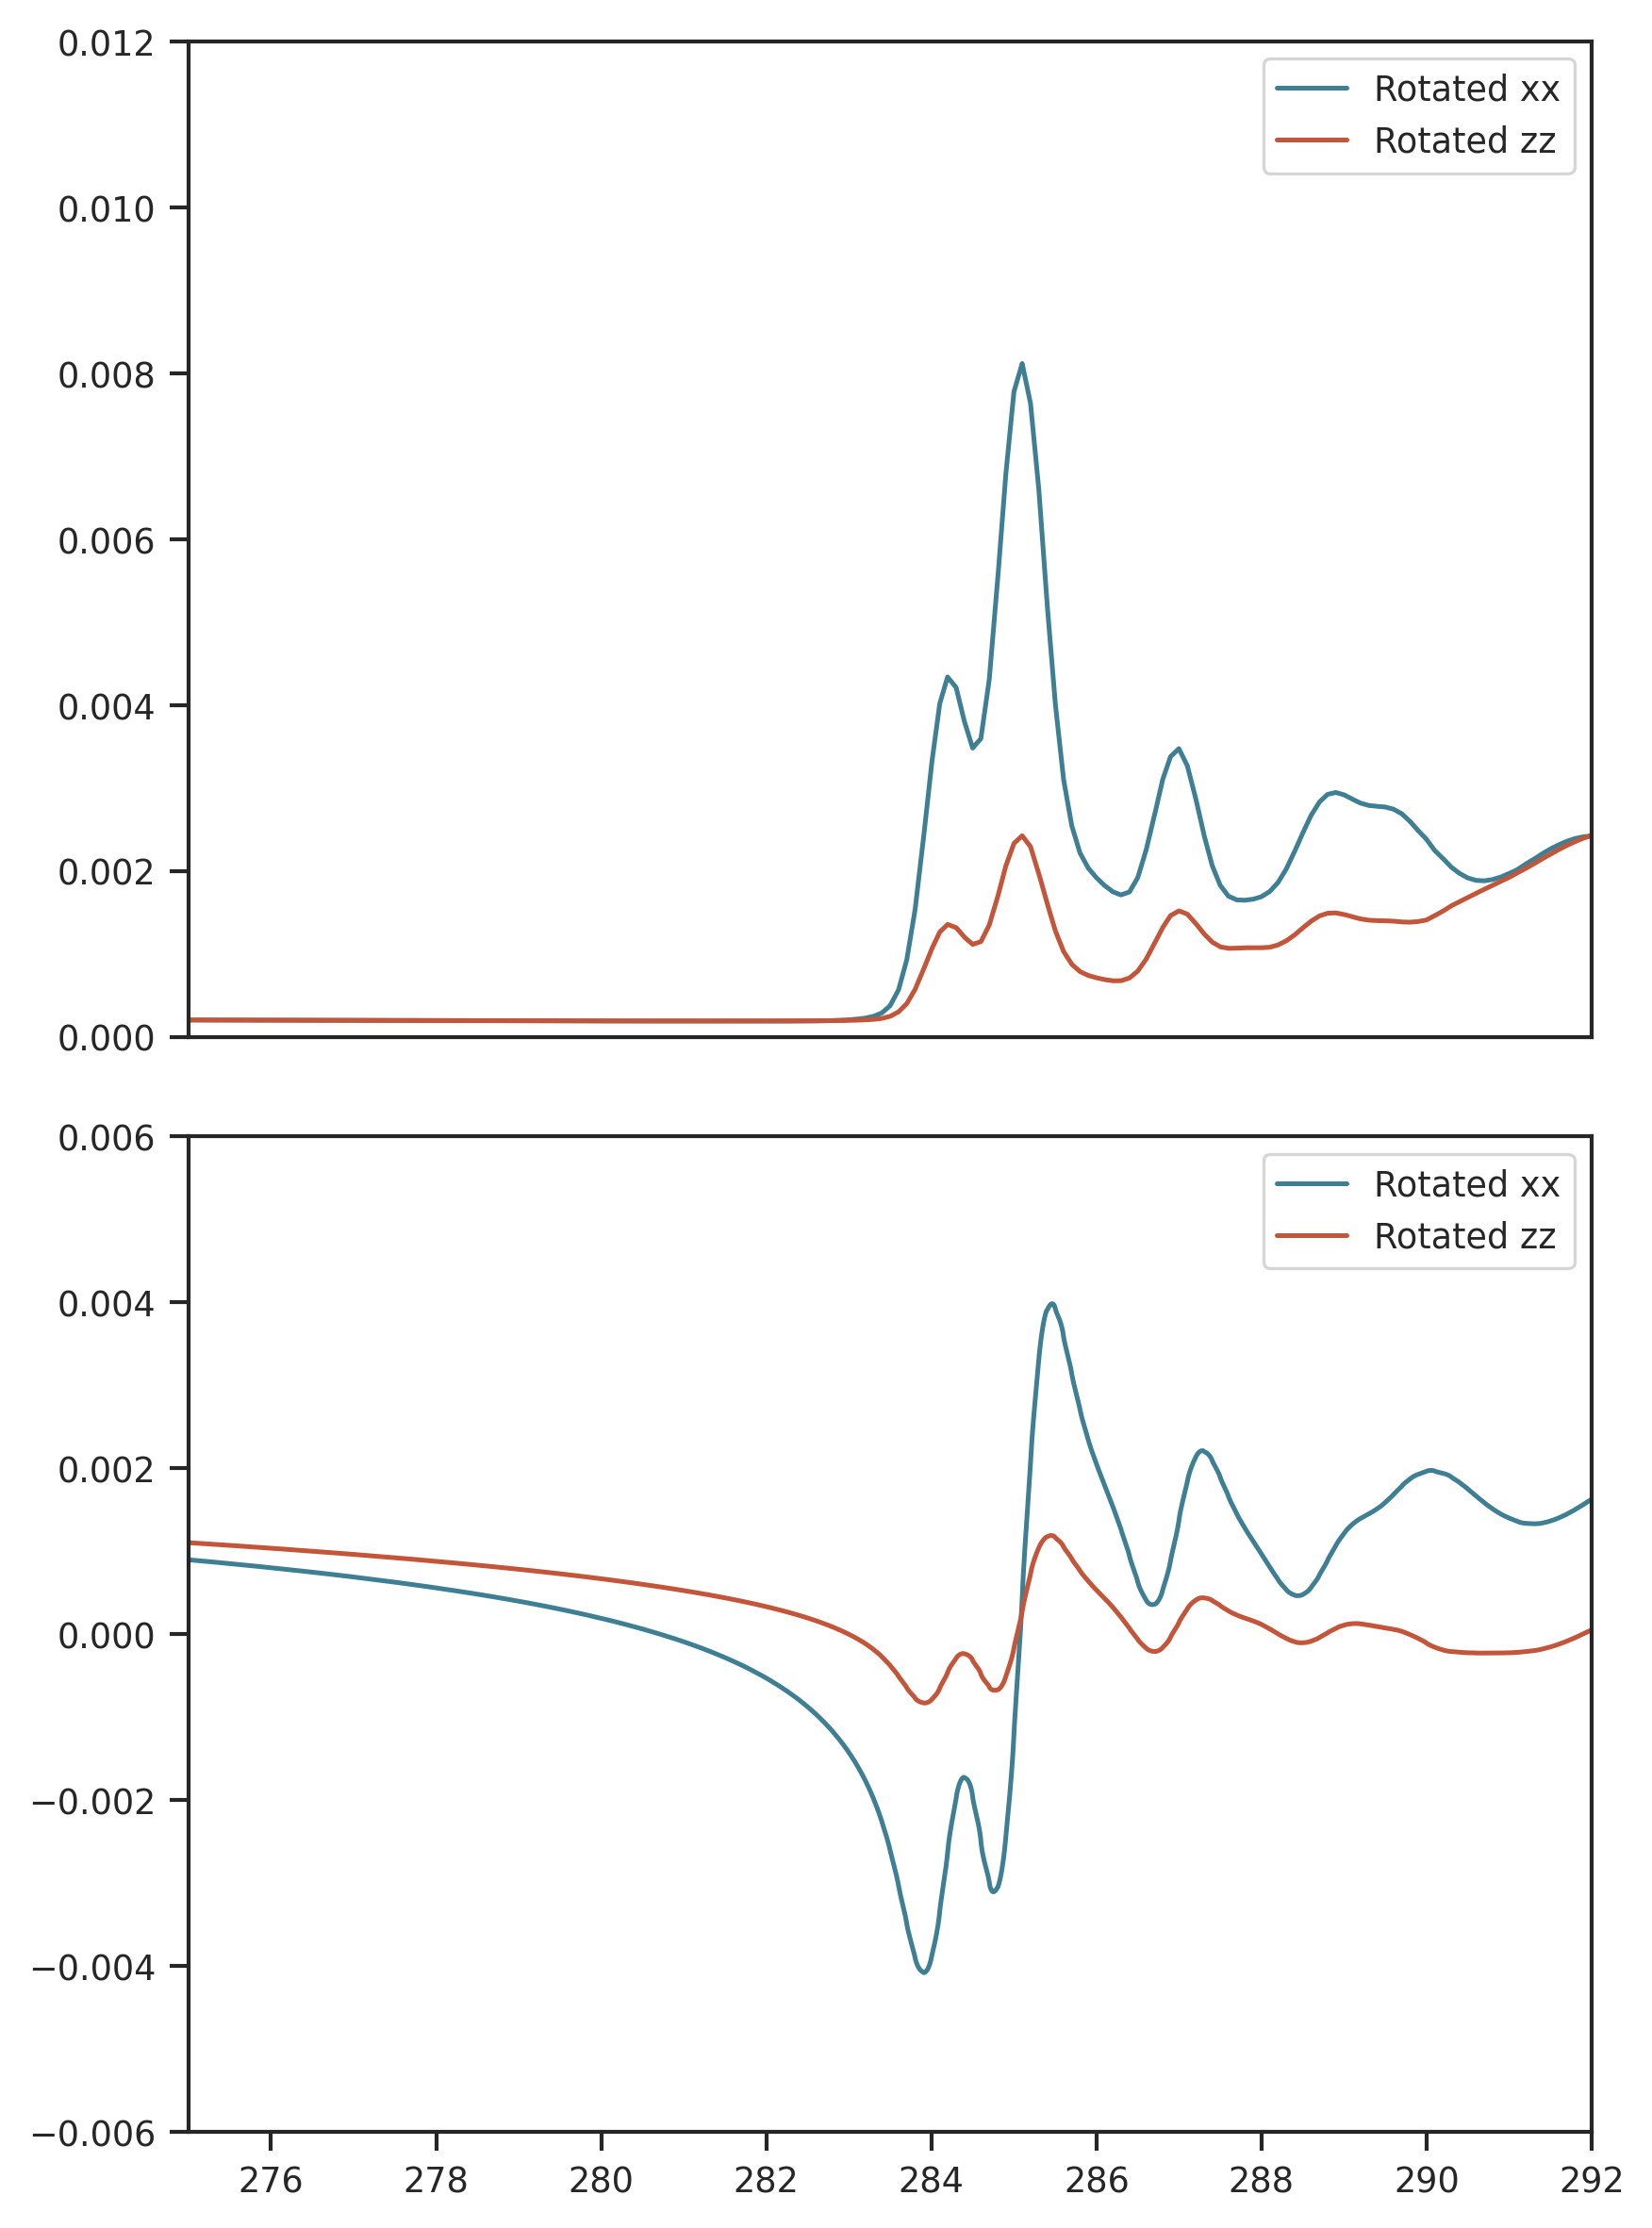

In [ ]:
# theta from molecular tilt angle in .cif file

theta = np.deg2rad(62)
r = R(theta)
n_r = r @ n @ r.T

fig, ax = plt.subplots(
    nrows=2, sharex=True, gridspec_kw={"hspace": 0.1}, figsize=(6.4, 9.6)
)

# ax[0].plot(en, n[:, 0, 0].imag, label="xx", color="C0")
# ax[0].plot(en, n[:, 1, 1].imag, label="zz", color="C1")
ax[0].plot(en, n_r[:, 0, 0].imag, label="Rotated xx", color="C0")
ax[0].plot(en, n_r[:, 1, 1].imag, label="Rotated zz", color="C1")
ax[0].set_xlim(250, 290)
ax[0].set_ylim(0, 0.012)
ax[0].tick_params(axis="x", which="both", bottom=False, top=False, labelbottom=False)
ax[0].legend()

# ax[1].plot(en, n[:, 0, 0].real, label="xx", color="C0")
# ax[1].plot(en, n[:, 1, 1].real, label="zz", color="C1")
ax[1].plot(en, n_r[:, 0, 0].real, label="Rotated xx", color="C0")
ax[1].plot(en, n_r[:, 1, 1].real, label="Rotated zz", color="C1")
ax[1].set_xlim(275, 292)
ax[1].set_ylim(-0.006, 0.006)
ax[1].legend()

# Model purely from DFT


In [ ]:
energy = [
    284.22241,
    285.06207,
    285.50906,
    286.10214,
    286.74417,
    287.07013,
    287.61008,
    288.15906,
    288.56741,
    288.87015,
    289.379,
    290.20575,
    291.74933,
    293.49863,
    295.36945,
    298.51926,
    303.15958,
    307.15552,
    313.49893,
]
amp = [
    0.013883271,
    0.02300393,
    0.0071607064,
    0.0042806831,
    0.0052673123,
    0.0069674319,
    0.0037899793,
    0.0045592617,
    0.0020791758,
    0.0062418138,
    0.0080258828,
    0.011401098,
    0.011617258,
    0.012487763,
    0.012987279,
    0.023565691,
    0.030651854,
    0.013345404,
    0.0072841011,
]
theta = [
    0.10986175,
    0.0099264169,
    0.010565368,
    2.0037124,
    9.6967077,
    1.749457,
    29.972015,
    28.981489,
    29.668104,
    9.5790854,
    22.045391,
    21.47336,
    52.5131,
    81.928589,
    84.008263,
    89.63591,
    89.614853,
    87.755257,
    40.949398,
]
wid = [
    0.68722975,
    0.63484478,
    0.78866369,
    0.73099136,
    0.68295568,
    0.57366711,
    0.60283935,
    0.64840037,
    0.51148295,
    0.6116873,
    0.87610269,
    1.0846148,
    2.0258183,
    2.5669038,
    3.1504252,
    5.0322709,
    6.6183276,
    7.6663713,
    9.2411699,
]
ip = [291.96863, 290.45758, 290.19235, 290.1377]
ecorr = [-1.6164246, -1.5892639, -1.5467224, -1.567749]

In [13]:
n_fit = pd.read_csv("C32H16N8Zn.fit")
n_fit = n_fit[n_fit["energy"].isin(n_fit["energy"].unique())]

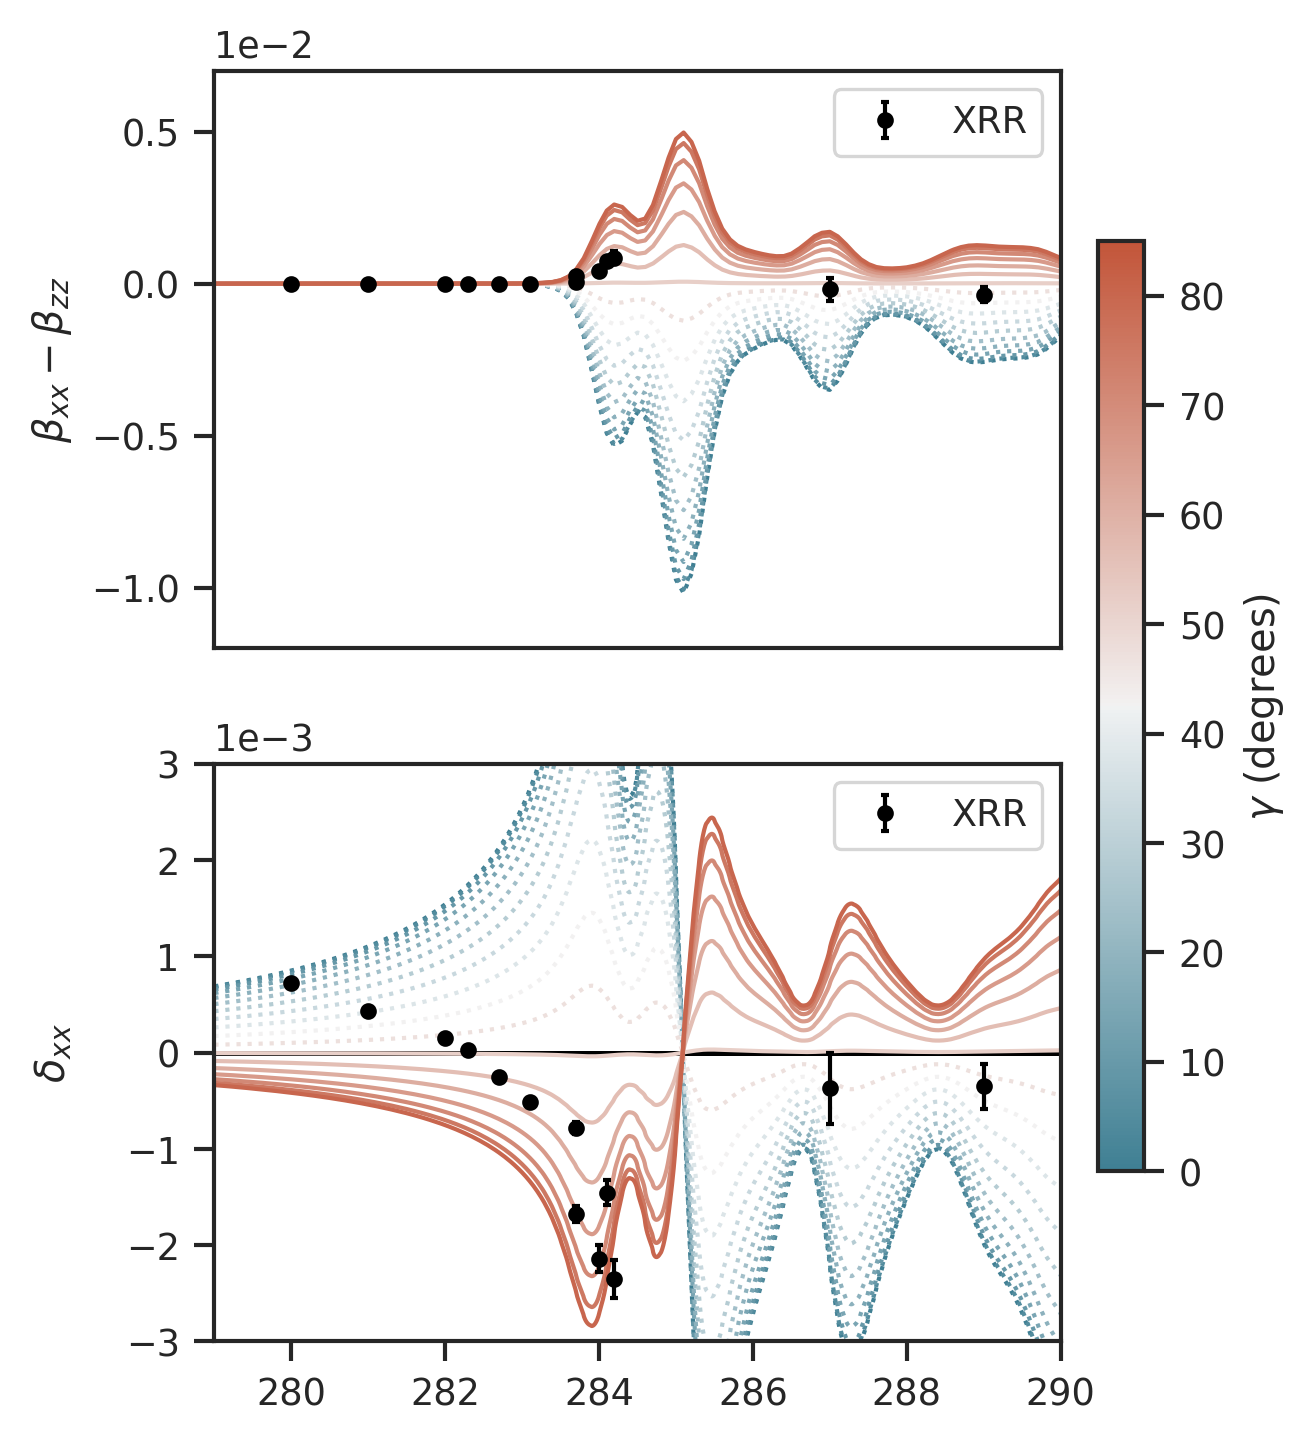

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.interpolate import interp1d
from matplotlib.ticker import ScalarFormatter

MA = np.rad2deg(np.arcsin(np.sqrt(2 / 3)))


# Define the colormap
thetas = np.arange(0, 90, 5)
cmap = sns.diverging_palette(220, 20, n=len(thetas), as_cmap=True)


def n_interp(en, deg):
    # Convert degree to radian
    theta = np.deg2rad(deg)

    # Extract components from the original n matrix (2000, 2, 2)
    n_xx = n[:, 0, 0]  # ordinary index
    n_zz = n[:, 1, 1]  # extraordinary index

    cos_squared = np.square(np.cos(theta))
    sin_squared = 1 - cos_squared

    # Calculate rotated components
    n_o = (n_xx * (1 + cos_squared) + n_zz * sin_squared) / 2
    n_e = n_xx * sin_squared + n_zz * cos_squared

    # Create the rotated matrix with shape (2000, 2, 2)
    n_rotated = np.zeros((len(en), 2, 2), dtype=complex)
    n_rotated[:, 0, 0] = n_o
    n_rotated[:, 1, 1] = n_e

    # Create interpolation function over the energy domain
    n_r_interp = interp1d(en, n_rotated, axis=0)

    return n_r_interp


n_interp_f = [n_interp(en, theta) for theta in thetas]

fig, ax = plt.subplots(
    nrows=2, sharex=True, gridspec_kw={"hspace": 0.2}, figsize=(4, 5.5)
)

# Create a ScalarFormatter object
formatter = ScalarFormatter(useMathText=True)
formatter.set_scientific(True)
formatter.set_powerlimits((-2, 2))

for i, n_r_interp in enumerate(n_interp_f):
    color = cmap(i / len(thetas))

    lw = 1
    ls = "-" if thetas[i] > MA else ":"
    s = 1

    ax[0].plot(
        en,
        n_r_interp(en)[:, 0, 0].imag - n_r_interp(en)[:, 1, 1].imag,
        alpha=s,
        lw=lw,
        ls=ls,
        color=color,
        zorder=1,
    )
    # ax[0].plot(en, n_r_interp(en)[:, 1, 1].imag, alpha = s, lw=lw, ls = ls, color=color)
    ax[1].plot(
        en,
        n_r_interp(en)[:, 0, 0].real - n_r_interp(en)[:, 1, 1].real,
        alpha=s,
        lw=lw,
        ls=ls,
        color=color,
        zorder=1,
    )
    # ax[1].plot(en, n_r_interp(en)[:, 1, 1].real, alpha = s, lw=lw, ls = ls, color=color)
ax[0].set_ylabel(r"$\beta_{xx} - \beta_{zz}$")
ax[1].set_ylabel(r"$\delta_{xx}$")
ax[0].errorbar(
    n_fit["energy"],
    n_fit["ixx"] - n_fit["izz"],
    0.1 * (n_fit["ixx"]),
    marker="o",
    color="k",
    ms=3,
    lw=0,
    elinewidth=1,
    capsize=1,
    ecolor="k",
    label="XRR",
)
ax[1].errorbar(
    n_fit["energy"],
    n_fit["xx"],
    0.1 * n_fit["ixx"],
    marker="o",
    color="k",
    ms=3,
    lw=0,
    elinewidth=1,
    capsize=1,
    ecolor="k",
    label="XRR",
)

# Add colorbar
sm = plt.cm.ScalarMappable(
    cmap=cmap, norm=plt.Normalize(vmin=thetas.min(), vmax=thetas.max())
)
sm.set_array([])
cbar = plt.colorbar(sm, ax=ax, orientation="vertical", fraction=0.05, pad=0.04)
cbar.set_label(r"$\gamma$ (degrees)")

ax[0].set_xlim(279, 290)
ax[0].set_ylim(-0.012, 0.007)
ax[0].tick_params(axis="x", which="both", bottom=False, top=False, labelbottom=False)
ax[0].ticklabel_format(style="sci", axis="y", scilimits=(0, 0))
ax[1].set_xlim(279, 290)
ax[1].ticklabel_format(style="sci", axis="y", scilimits=(0, 0))
ax[1].axhline(0, color="k", zorder=-1)
ax[1].set_ylim(-0.003, 0.003)
ax[1].legend()
ax[0].legend()

fig.align_ylabels(ax)

plt.show()

/tmp/ipykernel_881727/2404864918.py:51: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


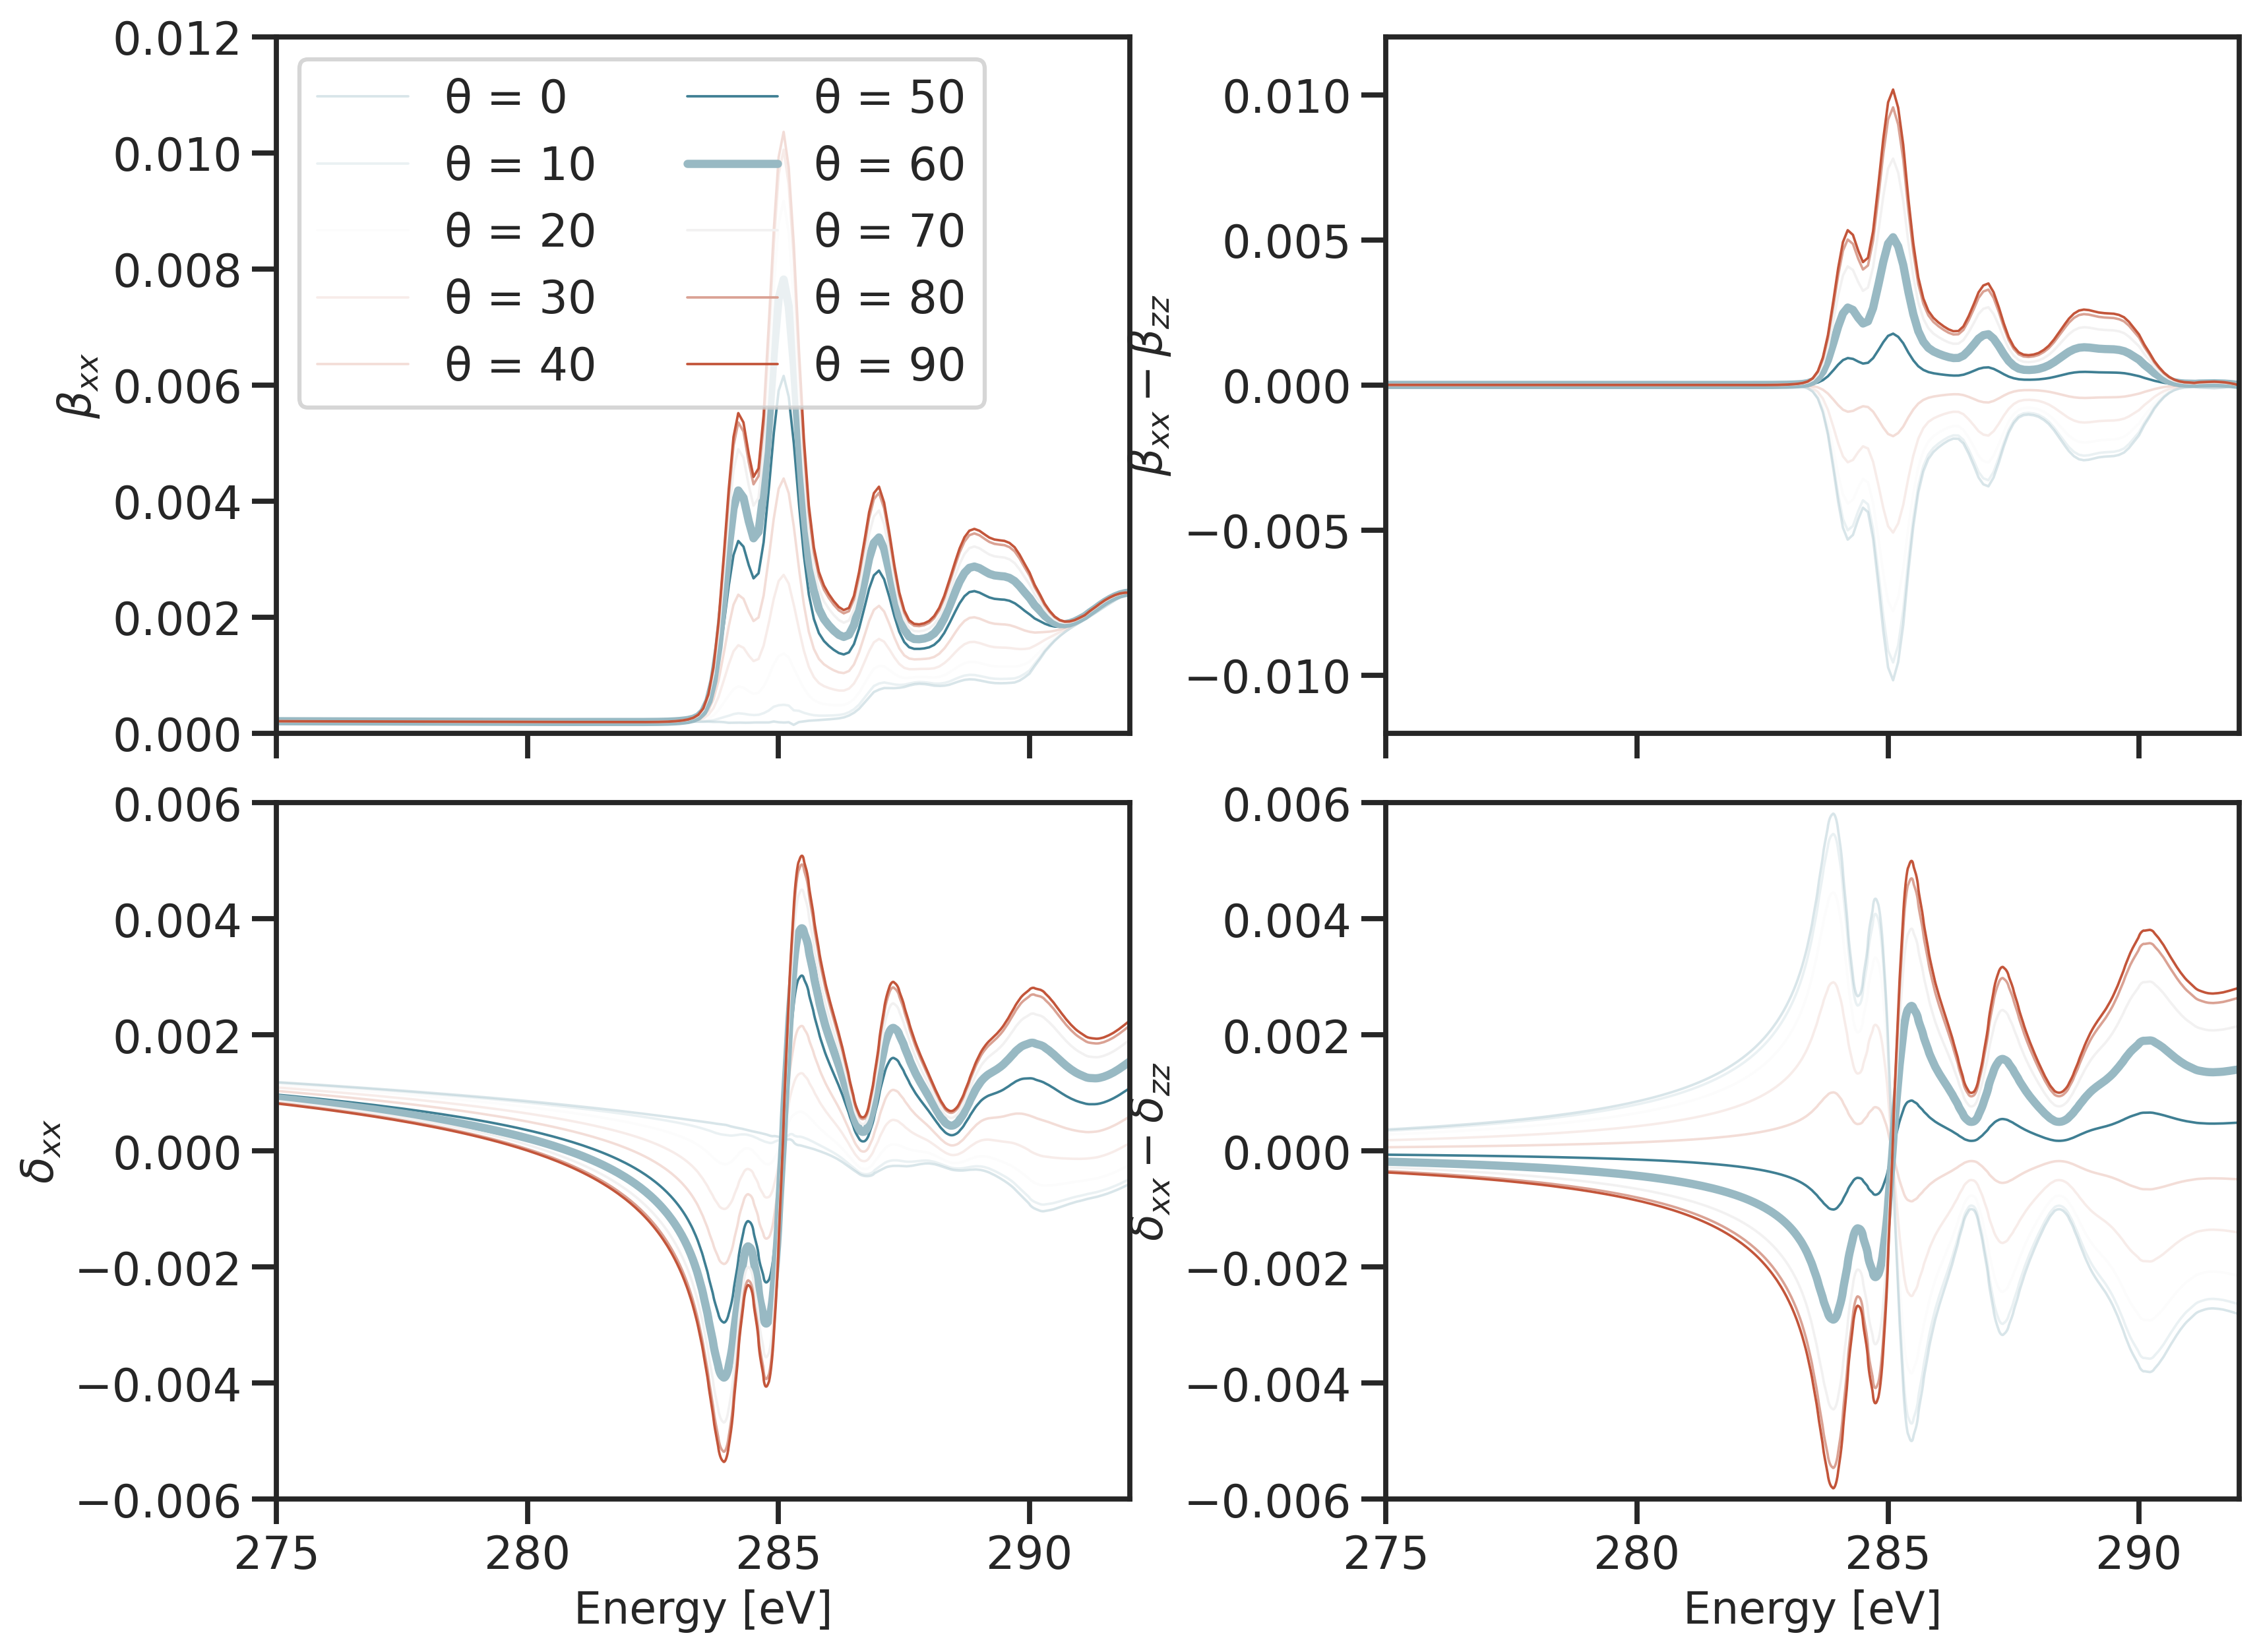

In [ ]:
import seaborn as sns

plt.rcParams.update({"figure.dpi": 300})
sns.set_context("talk")
sns.set_style("ticks")

sns.set_palette(sns.diverging_palette(220, 20, n=5))


def n_interp(en, deg):
    r = R(np.deg2rad(deg))
    n_r = r @ n @ r.T
    n_r_interp = interp1d(en, n_r, axis=0)
    return n_r_interp


thetas = np.linspace(0, 90, 10)
n_interp_f = [n_interp(en, theta) for theta in thetas]

fig, ax = plt.subplots(
    nrows=2,
    ncols=2,
    sharex=True,
    gridspec_kw={"hspace": 0.1, "wspace": 0.3},
    figsize=(12.8, 9.6),
)

for i, n_r_interp in enumerate(n_interp_f):
    s = 0.2 if i < 5 else 1
    lw = 3 if i == 6 else 0.9
    label = f"θ = {thetas[i]:.0f}"

    ax[0, 0].plot(en, n_r_interp(en)[:, 0, 0].imag, alpha=s, lw=lw, label=label)
    ax[0, 0].set_xlim(275, 292)
    ax[0, 0].set_ylim(0, 0.012)
    ax[0, 0].set_ylabel(r"$\beta_{xx}$", fontsize=16)
    dichroism = n_r_interp(en)[:, 0, 0].imag - n_r_interp(en)[:, 1, 1].imag

    ax[0, 1].plot(en, dichroism, alpha=s, lw=lw)
    ax[0, 1].set_xlim(275, 292)
    ax[0, 1].set_ylim(-0.012, 0.012)
    ax[0, 1].set_ylabel(r"$\beta_{xx} -\beta_{zz}$", fontsize=16)

    ax[1, 0].plot(en, n_r_interp(en)[:, 0, 0].real, alpha=s, lw=lw)
    ax[1, 0].set_xlim(275, 292)
    ax[1, 0].set_ylim(-0.006, 0.006)
    ax[1, 0].set_ylabel(r"$\delta_{xx}$", fontsize=16)
    ax[1, 0].set_xlabel("Energy [eV]", fontsize=16)

    biren = n_r_interp(en)[:, 0, 0].real - n_r_interp(en)[:, 1, 1].real

    ax[1, 1].plot(en, biren, alpha=s, lw=lw)
    ax[1, 1].set_xlim(275, 292)
    ax[1, 1].set_ylim(-0.006, 0.006)
    ax[1, 1].set_ylabel(r"$\delta_{xx} -\delta_{zz}$", fontsize=16)
    ax[1, 1].set_xlabel("Energy [eV]", fontsize=16)
ax[0, 0].legend(loc="upper left", ncols=2)
plt.tight_layout()

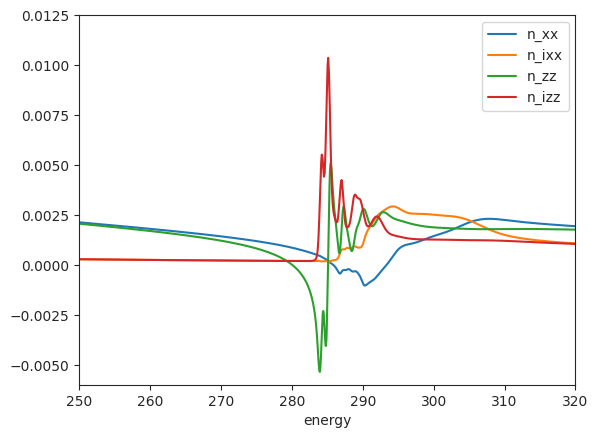

In [ ]:
# export the constants needed for fitting (face on - assume as 10, edge on - assume as 80)
import polars as pl

# Calculate for specific angles
angles = [0]
en_spec = np.arange(250, 320, 0.1)
n_specific = [n_interp(en, theta) for theta in angles]

# Create data dictionary
data = {
    "energy": en,
    "n_xx": n_specific[0](en)[:, 0, 0].real,
    "n_ixx": n_specific[0](en)[:, 0, 0].imag,
    "n_zz": n_specific[0](en)[:, 1, 1].real,
    "n_izz": n_specific[0](en)[:, 1, 1].imag,
}
df = pd.DataFrame(data)

df.plot(x="energy")
plt.xlim(250, 320)
plt.ylim(-6e-3, 1.25e-2)

df["energy"] = df["energy"]
df.to_csv("optical_constants.csv", index=False)

In [ ]:
# export the constants needed for fitting (face on - assume as 10, edge on - assume as 80)

# Calculate for specific angles
en_spec = np.arange(250, 320, 0.1)
print(len(en))
angles = [10, 80]
n_specific = [n_interp(en, theta) for theta in angles]

# Create data dictionary
data = {"Energy (eV)": en_spec}

for idx, theta in enumerate(angles):
    n_r = n_specific[idx](en_spec)

    # Optical constants
    data[f"Im(n_xx) {theta}°"] = n_r[:, 0, 0].imag
    data[f"Im(n_yy) {theta}°"] = n_r[:, 1, 1].imag
    data[f"Re(n_xx) {theta}°"] = n_r[:, 0, 0].real
    data[f"Re(n_yy) {theta}°"] = n_r[:, 1, 1].real

    # Dichroism and birefringence
    data[f"Dichroism {theta}°"] = n_r[:, 0, 0].imag - n_r[:, 1, 1].imag
    data[f"Birefringence {theta}°"] = n_r[:, 0, 0].real - n_r[:, 1, 1].real

# _ = [print(k, len(v)) for k, v in data.items()]
# Create DataFrame and export to CSV
df = pd.DataFrame(data)
df.to_csv("optical_constants.csv", index=False)

# Print first few rows to verify
print(df.head())

2314
   Energy (eV)  Im(n_xx) 10°  Im(n_yy) 10°  Re(n_xx) 10°  Re(n_yy) 10°  \
0        250.0      0.000281      0.000281      0.002126      0.002062   
1        250.1      0.000280      0.000280      0.002123      0.002059   
2        250.2      0.000280      0.000280      0.002120      0.002055   
3        250.3      0.000280      0.000280      0.002117      0.002052   
4        250.4      0.000279      0.000279      0.002113      0.002049   

   Dichroism 10°  Birefringence 10°  Im(n_xx) 80°  Im(n_yy) 80°  Re(n_xx) 80°  \
0  -5.421011e-20           0.000064      0.000281      0.000281      0.002062   
1  -5.421011e-20           0.000064      0.000280      0.000280      0.002059   
2  -5.421011e-20           0.000064      0.000280      0.000280      0.002055   
3  -5.421011e-20           0.000065      0.000280      0.000280      0.002052   
4   0.000000e+00           0.000065      0.000279      0.000279      0.002049   

   Re(n_yy) 80°  Dichroism 80°  Birefringence 80°  
0      0.00

,xx,zz,dxx,dzz,delta,ddelta,ixx,izz,dixx,dizz,beta,dbeta,energy
0,0.001153,0.001163,0.000013,0.000003,0.000939,NaN,0.000201,0.000201,0.000000e+00,0.000000e+00,0.000201,NaN,275.0
1,0.000727,0.000858,0.000051,0.000016,0.000329,NaN,0.000197,0.000197,2.181875e-10,2.224330e-10,0.000197,NaN,280.0
2,0.000428,0.000772,0.000031,0.000013,0.000081,NaN,0.000198,0.000198,6.298336e-07,6.415796e-07,0.000197,NaN,281.0
3,0.000149,0.000641,0.000030,0.000029,-0.000303,NaN,0.000199,0.000200,1.425224e-06,1.470028e-06,0.000198,NaN,282.0
4,0.000032,0.000615,0.000007,0.000024,-0.000469,NaN,0.000200,0.000200,1.555467e-06,1.578348e-06,0.000199,NaN,282.3


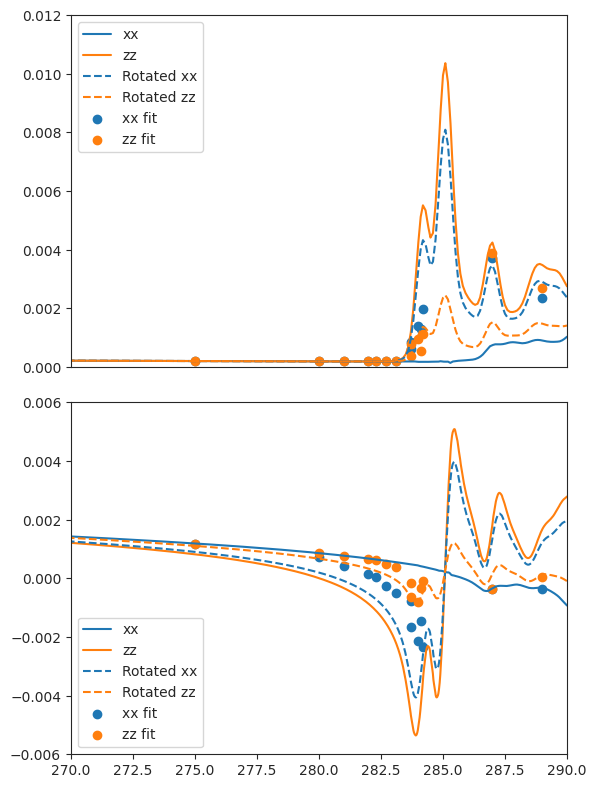

In [ ]:
# pull the csv data from the fitting results

fit = pd.read_csv("optical models/C32H16N8Zn.fit")

fig, ax = plt.subplots(
    nrows=2, sharex=True, gridspec_kw={"hspace": 0.1}, figsize=(6.4, 9.6)
)

ax[0].plot(en, n[:, 0, 0].imag, label="xx", color="C0")
ax[0].plot(en, n[:, 1, 1].imag, label="zz", color="C1")
ax[0].plot(en, n_r[:, 0, 0].imag, label="Rotated xx", color="C0", linestyle="--")
ax[0].plot(en, n_r[:, 1, 1].imag, label="Rotated zz", color="C1", linestyle="--")

ax[0].scatter(fit["energy"], fit["ixx"], color="C0", label="xx fit")
ax[0].scatter(fit["energy"], fit["izz"], color="C1", label="zz fit")

ax[0].set_xlim(270, 290)
ax[0].set_ylim(0, 0.012)
ax[0].tick_params(axis="x", which="both", bottom=False, top=False, labelbottom=False)
ax[0].legend()

ax[1].plot(en, n[:, 0, 0].real, label="xx", color="C0")
ax[1].plot(en, n[:, 1, 1].real, label="zz", color="C1")
ax[1].plot(en, n_r[:, 0, 0].real, label="Rotated xx", color="C0", linestyle="--")
ax[1].plot(en, n_r[:, 1, 1].real, label="Rotated zz", color="C1", linestyle="--")

ax[1].scatter(fit["energy"], fit["xx"], color="C0", label="xx fit")
ax[1].scatter(fit["energy"], fit["zz"], color="C1", label="zz fit")

ax[1].set_xlim(270, 290)
ax[1].set_ylim(-0.006, 0.006)
ax[1].legend()
display(fit.head())

# Fitting over the complex numbers

Since complex numbers do not originate from ther order axioms, there the residue computed by least squares must be real. To do this, we propose

$$
n = \left(Re[n_xx], Im[n_xx], Re[n_zz], Im[n_zz] \right)
$$


(270.0, 290.0)

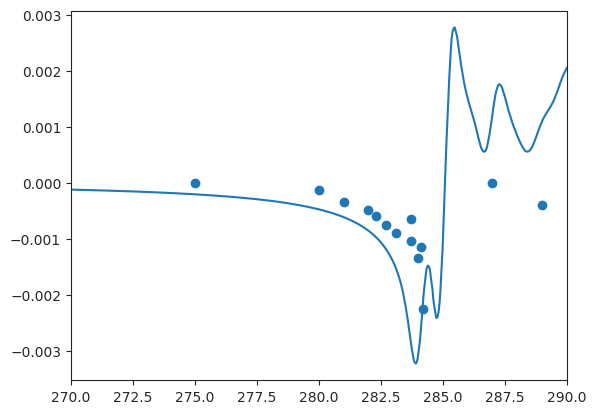

In [ ]:
from scipy.optimize import curve_fit

#  fit the birrefringence data
biref = fit["xx"] - fit["zz"]


plt.scatter(fit["energy"], biref)